# datatools

> Module to handle loading, preprocessing and postprocessing of point cloud data.

In [ ]:
#| default_exp datatools

In [ ]:
#| export
import torch
from torch.utils.data import Dataset
from torch import nn
import yaml
from pathlib import Path
import numpy as np

## [SemanticKITTI](https://arxiv.org/abs/1904.01416)

This is an adaptation of the [semantic-kitti-api](https://github.com/PRBonn/semantic-kitti-api) as a pytorch Dataset.

In [ ]:
#| export
class SemanticKITTIDataset(Dataset):
    "Load the SemanticKITTI data in a pytorch Dataset object."
    def __init__(self, data_path):
        data_path = Path(data_path)
        yaml_path = data_path/"semantic-kitti.yaml"
        self.velodyne_path = data_path/"velodyne"
        self.labels_path = data_path/"labels"
        
        velodyne_fns = list(self.velodyne_path.glob('*.bin'))
        self.frame_ids = [fn.stem for fn in velodyne_fns]
        
        with open(yaml_path, 'r') as file:
            metadata = yaml.safe_load(file)
        
        self.labels_dict = metadata.get('labels', {})
        self.learning_map = metadata.get('learning_map', {})
        self.learning_map_inv = metadata.get('learning_map_inv', {})
        self.color_map_bgr = metadata.get('color_map', {})
        
        self.transform = None

    def set_transform(self, transform):
        self.transform = transform
    
    def __len__(self):
        return len(self.frame_ids)

    def __getitem__(self, idx):
        frame_id = self.frame_ids[idx]
        
        frame_path = self.velodyne_path/(frame_id + '.bin')
        with open(frame_path, 'rb') as f:
            frame = np.fromfile(f, dtype=np.float32).reshape(-1, 4)
        
        label_path = self.labels_path/(frame_id + '.label')
        with open(label_path, 'rb') as f:
            label = np.fromfile(f, dtype=np.uint32)
            label = label & 0xFFFF
        label = np.vectorize(self.learning_map.get)(label)
        label = label.astype(int)

        mask = None
        
        if self.transform:
            frame, label, mask = self.transform(frame, label)
        
        return frame, label, mask

Here is an example on how to use it in its raw format:

In [ ]:
#| eval: false
data_path = '../../Cloud2DImageConverter/point_clouds/semantic_kitti/'
ds = SemanticKITTIDataset(data_path)
ds[0]

(array([[78.517075 , 14.267936 ,  2.9050329,  0.       ],
        [78.234505 , 14.852934 ,  2.8988407,  0.       ],
        [77.76288  , 15.016934 ,  2.883781 ,  0.       ],
        ...,
        [ 3.8050973, -1.4180834, -1.745158 ,  0.24     ],
        [ 3.834471 , -1.4160812, -1.7571627,  0.3      ],
        [ 3.8348432, -1.4030806, -1.7561686,  0.       ]], dtype=float32),
 array([0, 0, 0, ..., 9, 9, 9]),
 None)

In [ ]:
#| export
class SphericalProjectionTransform(nn.Module):
    "Pytorch transform that turns a point cloud frame and its respective label into spherical projection images."
    def __init__(self, fov_up_deg, fov_down_deg, W, H):
        super().__init__()
        self.fov_up_rad = (fov_up_deg/180.)*np.pi
        self.fov_down_rad = (fov_down_deg/180.)*np.pi
        self.fov_rad = abs(self.fov_down_rad) + abs(self.fov_up_rad)
        self.W = W
        self.H = H
        
    def forward(self, frame, label):
        # get point_cloud components
        scan_xyz = frame[:,:3]
        reflectance = frame[:, 3]

        assert reflectance.max() <= 1.
        assert reflectance.min() >= 0.

        # get depths of all points
        depth = np.linalg.norm(scan_xyz, 2, axis=1)
        
        # get angles of all points
        yaw = np.arctan2(scan_xyz[:,1], scan_xyz[:,0])
        pitch = np.arcsin(scan_xyz[:,2] / depth)
        
        # get projections in image coords (between [0.0, 1.0])
        proj_x = 0.5 * (yaw / np.pi + 1.0)
        proj_y = (abs(self.fov_up_rad) - pitch)/self.fov_rad

        assert proj_x.min() >= 0.
        assert proj_x.max() <= 1.
        assert proj_y.min() >= 0.
        assert proj_y.min() <= 1.
        
        # scale to image size using angular resolution (between [0.0, W/H])
        proj_x *= self.W
        proj_y *= self.H
        
        # round and clamp to use as indices (between [0, W/H - 1])
        proj_x = np.floor(proj_x)
        proj_x = np.clip(proj_x, 0, self.W - 1).astype(int)
        
        proj_y = np.floor(proj_y)
        proj_y = np.clip(proj_y, 0, self.H - 1).astype(int)
        
        # order in decreasing depth
        order = np.argsort(depth)[::-1]
        scan_xyzrdl = np.concatenate((scan_xyz, 
                                      reflectance[..., np.newaxis],
                                      depth[..., np.newaxis],
                                      label[..., np.newaxis]),
                                     axis=-1)
        scan_xyzrdl = scan_xyzrdl[order]
        proj_y = proj_y[order]
        proj_x = proj_x[order]
        
        # setup the image tensor
        projections_img = np.zeros((self.H, self.W, 6))
        projections_img[:,:,-1] -= 1 # this helps to identify points in the projection with no lidar readings
        projections_img[proj_y, proj_x] = scan_xyzrdl
        
        # frame image
        frame_img = projections_img[:,:,:-1]
        # label image
        label_img = projections_img[:,:,-1].astype(int)
        # mask image
        mask_img = projections_img[:,:,-1]>=0
        
        return frame_img, label_img, mask_img

In [ ]:
#| export
class ProjectionVizTransform(nn.Module):
    "Pytorch transform to preprocess sphererical projection images for proper visualization."
    def __init__(self, color_map_bgr, learning_map_inv):
        super().__init__()
        self.learning_map_inv_np = np.zeros((len(learning_map_inv),))
        for k, v in learning_map_inv.items():
            self.learning_map_inv_np[k] = v
        
        max_key = sorted(color_map_bgr.keys())[-1]
        self.color_map_rgb_np = np.zeros((max_key+1, 3))
        for k, v in color_map_bgr.items():
            self.color_map_rgb_np[k] = np.array(v[::-1], np.float32)
    
    def normalize(self, img, min_value, max_value):
        assert img.max() <= max_value
        assert img.min() >= min_value
        assert max_value > min_value
        
        img = img.clip(min_value, max_value)
        return (255.*(img - min_value)/(max_value - min_value)).astype(int)
    
    def forward(self, frame_img, label_img, mask_img):
        x = self.normalize(frame_img[:,:,0], -100., 100.)
        y = self.normalize(frame_img[:,:,1], -100., 100.)
        z = self.normalize(frame_img[:,:,2], -20., 5.)
        r = self.normalize(frame_img[:,:,3], 0., 1.)
        d = self.normalize(frame_img[:,:,4], 0., 100.)
        normalized_frame_img = np.stack((x, y, z, r, d), axis=-1)
        normalized_frame_img[mask_img == False] *= 0
        
        label_img[mask_img] = self.learning_map_inv_np[label_img[mask_img]]
        colored_label_img = np.zeros(label_img.shape + (3,))
        colored_label_img[mask_img] = self.color_map_rgb_np[label_img[mask_img]]
        
        colored_label_img = colored_label_img.astype(int)
        
        return normalized_frame_img, colored_label_img, mask_img

Here is an example on how to use and compose these transforms with the *torchvision.transforms.v2* module:

In [ ]:
#| eval: false
from torchvision.transforms import v2

In [ ]:
#| eval: false
tfms = v2.Compose([
    SphericalProjectionTransform(fov_up_deg=4., fov_down_deg=-26., W=1024, H=64),
    ProjectionVizTransform(ds.color_map_bgr, ds.learning_map_inv),
])
ds.set_transform(tfms)
img, label, _ = ds[0]

In [ ]:
#| eval: false
%timeit img, label, _ = ds[0]

23.8 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
#| eval: false
from matplotlib import pyplot as plt

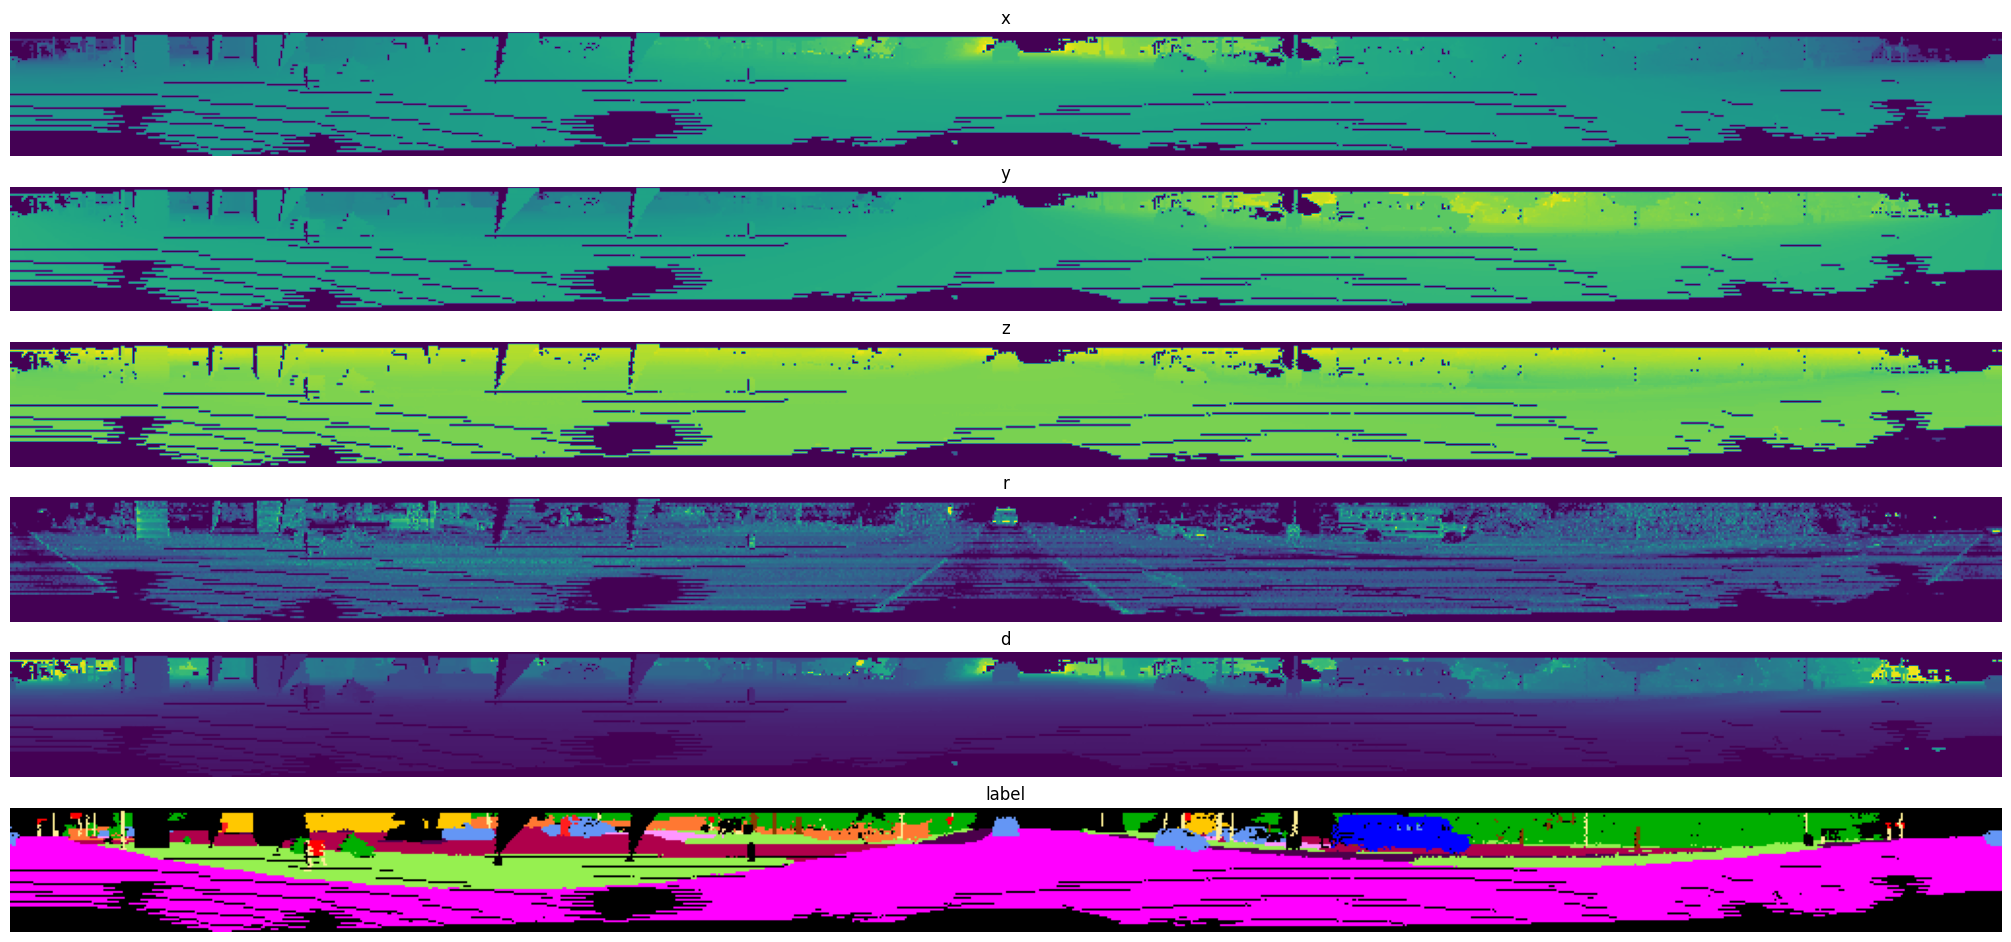

In [ ]:
#| eval: false
fig, axs = plt.subplots(6, 1, figsize=(20,10), layout='compressed')
for i, (ax, title) in enumerate(zip(axs, ['x', 'y', 'z', 'r', 'd', 'label'])):
    if i < 5:
        ax.imshow(img[:,:,i])
    else:
        ax.imshow(label)
    ax.set_title(title)
    ax.axis('off')

In [ ]:
#| export
class ProjectionToTensorTransform(nn.Module):
    "Pytorch transform that converts the projections from np.array to torch.tensor. It also changes the frame image format from (H, W, C) to (C, H, W)."
    def forward(self, frame_img, label_img, mask_img):
        frame_img = np.transpose(frame_img, (2, 0, 1))
        frame_img = torch.from_numpy(frame_img).float()
        label_img = torch.from_numpy(label_img)
        mask_img = torch.from_numpy(mask_img)
        return frame_img, label_img, mask_img

Here is an example on how to use it:

In [ ]:
#| eval: false
tfms = v2.Compose([
    SphericalProjectionTransform(fov_up_deg=4., fov_down_deg=-26., W=1024, H=64),
    ProjectionToTensorTransform(),
])
ds.set_transform(tfms)
img, label, mask = ds[0]
print(img.shape, img.type())
print(label.shape, label.type())
print(mask.shape, mask.type())

torch.Size([5, 64, 1024]) torch.FloatTensor
torch.Size([64, 1024]) torch.LongTensor
torch.Size([64, 1024]) torch.BoolTensor


Here is an example on how to combine the classes above to implement a *torch.utils.data.Dataloader* that iterates on batches of frame images, labels and masks:

In [ ]:
#| eval: false
from torch.utils.data import DataLoader

In [ ]:
#| eval: false
bs = 3
dl = DataLoader(ds, bs)
for batch in dl:
    img, label, mask = batch
    print(f"Shape of img \t [N, C, H, W]: \t {img.shape}")
    print(f"Shape of label \t [N, H, W]: \t {label.shape}")
    print(f"Shape of mask \t [N, H, W]: \t {mask.shape}")
    break

Shape of img 	 [N, C, H, W]: 	 torch.Size([3, 5, 64, 1024])
Shape of label 	 [N, H, W]: 	 torch.Size([3, 64, 1024])
Shape of mask 	 [N, H, W]: 	 torch.Size([3, 64, 1024])


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()